# Final Project
This project aims to use similar-item sets techniques to find plagiarised news articles and classify them according to genres using unsupervised machine learning methods.
Furthermore, it is also examined to what extent clustering can be used to find plagiarised articles and how it compares with standard techniques such as minhashing and lsh. 

In [390]:
import os
import mmh3
import numpy as np
import collections
import pandas as pd
from datasketch import MinHash, MinHashLSH
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import LdaMulticore, LdaModel
from gensim import matutils as genmath, corpora, models
from itertools import tee
import pickle
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE


DATA_SIZE=50000

### Utilities

In [301]:
#################### Utilities ######################
#hashes a list of strings
def listhash(l,seed):
	val = 0
	for e in l:
		val = val ^ mmh3.hash(e, seed)
	return val 

''' Extension of standard pairwise function to 3-pairwise from the py standard lib'''
def three_pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    # three_pairwise('ABCDEFG') --> ABC BCD CDE DEF EFG FG
    a, b, c = tee(iterable, 3) ## Create three iterators
    next(b, None) ## Advance the second
    next(c, None) ## Advance the third
    next(c, None) ## Advance the third once again. This ensures the third iterator starts at the third element and that we can create the 3-tuple
    return zip(a, b, c) ### Zip everything (1 elem, 2 elem, and 3 elem) concurrently.

''' Tokenize data and clean using NLTK package'''
stop = set(stopwords.words('english'))
def clean(text):

    tokens = word_tokenize(text)
    # Remove the punctuations, lower tokens and remove stopword
    tokens = [word.lower() for word in tokens if word not in stop and len(word) > 2]
   
    return tokens

def stored_pickled_pairs(pairs, filename):
    with open(f"{filename}.pickle", "wb") as handle:
        pickle.dump(pairs, handle, pickle.HIGHEST_PROTOCOL)

### Data preprocessing

In [391]:
''' Load DATA_SIZE amount of data/news articles'''
ROOT_DIR = os.path.abspath(os.curdir)
data = pd.read_csv(ROOT_DIR+"\\data\\articles1.csv")
data_content = data[:DATA_SIZE]["content"] #we are only interested in the content in each news

Only run the below cell for hashing. Clustering has its own cleaning cell in its own section.

In [303]:
''' Clean data '''
cleaned_docs=[clean(data) for data in data_content]

''' Create 3-pair shingles'''
def shingle_docs(doc, k=1000):
    
    three_tup=list(three_pairwise(doc))
    three_tup=[elem for elem in three_tup if len(elem)==3]
    return three_tup

''' Listhash a doc, represented by a list of shingles (3-wise) '''
def hash_doc(doc):
    seed=1
    return np.array(sorted([listhash(shingle, seed) for shingle in doc]))

''' Shingle the entire dataset '''
shingled_docs = list(map(shingle_docs, cleaned_docs))

## Minhashing own implementation

In [304]:
# test_docs=list(zip(["You and me, we made a vow. For better or for worse. I can't believe you let me down",
# "Time, space and state. Equal everything explanable.",
# "You and me, we made a vow. For better or for worse. I can't believe you let me down"]))
seed=1
hashed_shingles=list(map(hash_doc, shingled_docs))
# hashed_shingles=np.array(sorted([listhash(shingle, seed) for shingle in shingled_docs]))
print(len(hashed_shingles))
hashed_shingles=[lst for lst in hashed_shingles if len(lst)>100]
# hashed_shingles
sig_m=np.array(hashed_shingles) #5000x100 -> 100x5000
print(sig_m.shape)

50000
(43985,)


C:\Users\hasee\AppData\Local\Temp\ipykernel_18236\4217812439.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig_m=np.array(hashed_shingles) #5000x100 -> 100x5000


In [305]:
lens=min([len(x) for x in sig_m])
print(lens)
num_docs=sig_m.shape[0]
for i in range(num_docs):
    sig_m[i]=sig_m[i][:lens]
sig_m=np.stack(sig_m).T
sig_m.shape

101


(101, 43985)

### LSH implementation

In [306]:
''' Jaccard similarity'''
def jaccard(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

''' Implementation of LSH, dividing signature matrix into b band with r rows each'''
def LSH(sig_m, b, r):
    b=20
    r=5
    #b*r=num_hash_funcs

    sim_hashes=[]
    start=0
    for i in range(b):
        sim_hashes.append([listhash(col, seed=i) for col in sig_m[start:start+r,:].T])
        start=i+r

    return sim_hashes

''' Find candidate pairs by checking to see if the hashes match.
Then we check to see that the Jaccard similarity b/w each pair of docs is atleast t. If so, we consider it a candidate pair otherwise not '''
def get_cand_pairs(sim_hashes, t):
    cand_pairs=set()
    for L in sim_hashes:
        dups = collections.defaultdict(list)
        for i, e in enumerate(L):
            dups[e].append(i)
        for _, v in sorted(dups.items()):
            if len(v) >= 2:
                cand_pairs.add(tuple(v))
    cand_pairs=list(cand_pairs)
    filtered_cand_pairs = [pair for pair in cand_pairs if (jaccard(set(sig_m[:, pair[0]]), set(sig_m[:, pair[1]])) > t)]
    return filtered_cand_pairs
   

In [307]:
b=20
r=5
sim_hashes = LSH(sig_m, b=20, r=5)
pairs1=get_cand_pairs(sim_hashes, t=(1/b)**(1/r)) ## threshold = 0.549
# print(sig_m.shape)

36

In [308]:
print(len(pairs1))
stored_pickled_pairs(pairs1, "pairs1")

(101, 43985)


## Minhashing using package

In [309]:
'''num_perm is the number of permutations we want for the MinHash algorithm ,the higher the permutations the longer the runtime.
   min_dict1 maps each documents with the form of shingles to min hash signatures. We loop through all the set representations of 
   questions and calculate the signatures and store them in the min_dict1 dictionary'''
num_perm = 100
min_dict1 = {}
count3 = 1
for val in tqdm(shingled_docs):
    m = MinHash(num_perm=num_perm)
    for shingle in val:    
      a= []
      for i in shingle:
        i.encode('utf8')
        a.append(i)
      data1 = str(['_'.join(a)])

      m.update(data1.encode('utf8'))
    min_dict1["m{}".format(count3)] = m
    count3+=1

100%|██████████| 50000/50000 [06:31<00:00, 127.71it/s] 


In [310]:
'''We set the Jaccard similarity threshold as a parameter in MinHashLSH. We loop through the signatures or keys 
   in the min_dict dictionary ,Datasketch stores these in a dictionary format, where the key is a document
   and the value is other documents deemed similar based on the threshold. '''        
lsh = MinHashLSH(threshold=0.549, num_perm=num_perm)
for key in tqdm(min_dict1.keys()):
    lsh.insert(key,min_dict1[key]) # insert minhash data structure

100%|██████████| 50000/50000 [02:53<00:00, 287.91it/s] 


In [311]:
''' This function works with the dictionary output of the LSH to to output candidate pairs. '''
def create_cand_pairs():
    big_list = []
    for query in min_dict1.keys():
        bucket = lsh.query(min_dict1[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list

 We found that there are so many repetitive pairs so that we have to remove those repetitive pairs

In [312]:
cand_pairs = create_cand_pairs() #Create candidate pairs.
pairs2 = [i for i in cand_pairs if i[1] != 'None'] #Remove pairs contain "None".

#Create set to store unique candidate pairs.
pair_set = set()
for pair in pairs2:
    pair_set.add(tuple(pair))

candidate_pairs=list(pair_set)

In [313]:
print(len(candidate_pairs))
stored_pickled_pairs(candidate_pairs, "pairs2")

325


## Topic Modeling

In [332]:
''' Load the stored pairs '''
with open("pairs2.pickle", "rb") as handle:
    loaded_pairs = pickle.load(handle)

In [358]:
''' flatten the list of tuples to get a single list containing the index of each plagiarised news article '''
from itertools import chain

lst_plag_news = list(chain.from_iterable(loaded_pairs))
lst_plag_news = [item[1:] for item in lst_plag_news] ## remove "m" symbol to make indexing easier later
lst_plag_news = list(set(lst_plag_news)) ## remove duplicates
print(len(lst_plag_news))

In [361]:
''' Extract documents indexed by elements from lst_plag_news '''
extraced_docs = [cleaned_docs[int(index)] for index in lst_plag_news]

In [364]:
''' Create a BoW representation of the extracted_docs '''
dictionary = corpora.Dictionary()
BoW_corpus = [
   dictionary.doc2bow(doc, allow_update=True) for doc in extraced_docs
]

In [365]:
''' Apply the LDA algorithm '''
lda_model = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=10)

In [366]:
#Calculate the topic probality for each document
topic_prob =lda_model.get_document_topics(BoW_corpus) 

In [368]:
#Create a dic to store the topic for each dicument, we take the topic with the biggest probability as the topic of that document.
topic_document = {}
for i in enumerate(topic_prob):
    max = 0
    for j in i[1]:
        if j[1] > max:
            max = j[1]
            topic_document[i[0]] = j[0]

topic_num = []
for k,v in topic_document.items():
    topic_num.append(v)

In [372]:
from collections import Counter
topic_counter = Counter(topic_num)
print(topic_counter.most_common())

In [374]:
topic_num_list = []
for i in range(10):
    topic_num_list.append(topic_counter[i])

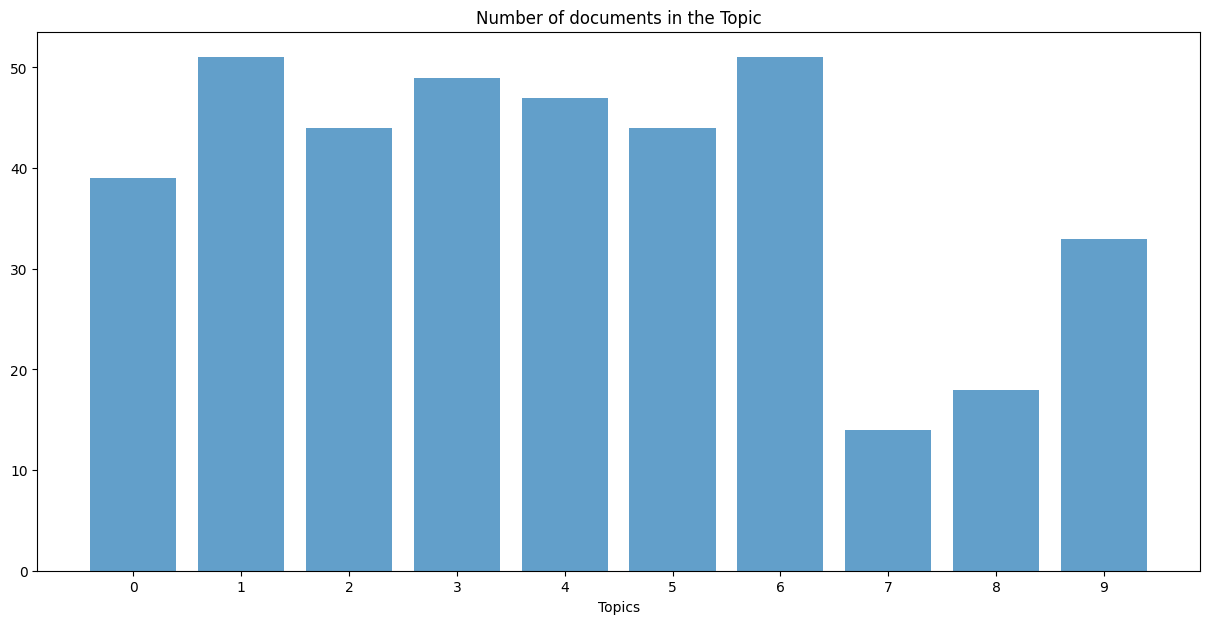

In [377]:
# coding=utf-8
from matplotlib import pyplot as plt
from matplotlib import font_manager
 
plt.figure(figsize=(15,7)) 
plt.bar(range(10),topic_num_list,align='center', alpha=0.7, ecolor='black', capsize=10)
plt.xticks(range(10),range(10))
plt.xlabel("Topics")
plt.title('Number of documents in the Topic')
plt.show()

In [604]:
tmp_dict={0:[],1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]} ## cluster_id => document_id list, tmp_dict[i] returns all documents with cluster i
for k,v in topic_document.items():
    tmp_dict[v] += [k]


In [608]:
tmp_dict[3]

[8,
 11,
 21,
 59,
 76,
 81,
 86,
 88,
 95,
 97,
 111,
 116,
 137,
 143,
 145,
 152,
 157,
 164,
 168,
 176,
 178,
 187,
 200,
 206,
 215,
 244,
 245,
 249,
 257,
 269,
 278,
 289,
 290,
 291,
 301,
 306,
 310,
 312,
 316,
 328,
 330,
 352,
 356,
 367,
 371,
 381,
 385,
 388,
 389]

In [599]:
data_content[16]

'  pages into the   journal found in Dylann S. Roof’s car  —   after the assertions of black inferiority, the lamentations over white powerlessness, the longing for a race war  —   comes an incongruous declaration. “I want state that I am morally opposed to psychology,” wrote the young white supremacist who would murder nine black worshipers at Emanuel A. M. E. Church in Charleston, S. C. in June 2015. “It is a Jewish invention, and does nothing but invent diseases and tell people they have problems when they dont. ” Mr. Roof, who plans to represent himself when the penalty phase of his federal capital trial begins on Tuesday, apparently is devoted enough to that proposition (or delusion, as some maintain) to stake his life on it. Although a defense based on his psychological capacity might be his best opportunity to avoid execution, he seems steadfastly committed to preventing any public examination of his mental state or background. “I will not be calling mental health experts or pre

## Clustering

In [392]:
cleaned_docs_cluster=[str([' '.join(clean(data))]) for data in data_content]

In [393]:
#Count Vectoriser then tidf transformer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cleaned_docs_cluster)
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(X)

### Find the optimal epsilon value 
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

In [394]:
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(tfidf.T)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(tfidf.T)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

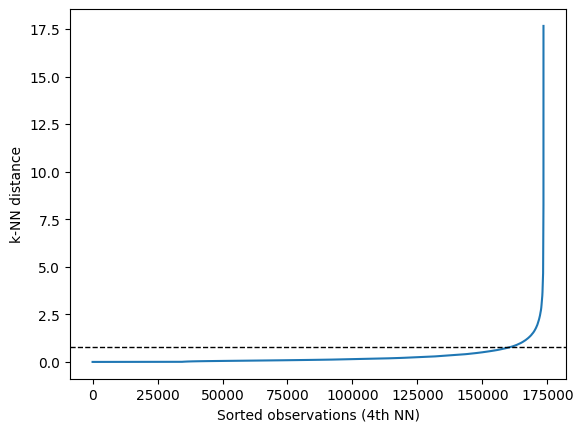

In [579]:
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=0.8, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

The optimal eps value is at the point of maximum curvature on the graph above. We use the second derivate to approxiamte this.
https://stackoverflow.com/questions/4471993/compute-the-elbow-for-a-curve-automatically-and-mathematically

In [396]:
# secondDerivative=[]
# x=k_dist
# for i in range(1, len(x)-1):
#     res = x[i+1] + x[i-1] - 2 * x[i]
#     secondDerivative.append(res)
# eps=max(secondDerivative)
# print(eps)
eps=0.8

### Compute DBSCAN clustering

In [ ]:
''' Load the stored tfidf matrix '''
# with open("pairs2.pickle", "rb") as handle:
    # tf = pickle.load(handle)

In [609]:
# eps = 0.8
import scipy
km = DBSCAN(eps=eps, min_samples=5)
km.fit(tfidf)
print(km.labels_)
clusters = km.labels_.tolist()

[-1 -1 -1 ... -1 -1 -1]


In [610]:
print("number of clusters", len(list(set(clusters))))

number of clusters 132


In [611]:
plag_articles_clustering = [i for i in range(len(clusters)) if clusters[i]!=-1] ## gives the list of plagiarised articles

In [612]:
# count of plagirized documents 
from collections import Counter
count = Counter(clusters)
print("number of plagiarised articles", sum([count[item] for item in count if item!=-1])) # not counting the -1 cluster 
count_dic = dict(sorted(count.items()))
del count_dic[-1] ## remove -1 keys 

number of plagiarised articles 1489


### Plotting number of articles per cluster

<BarContainer object of 131 artists>

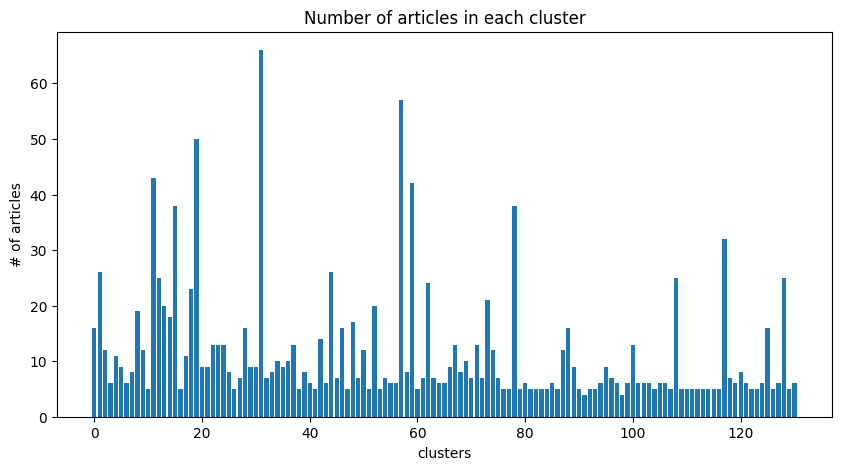

In [613]:
plt.figure(figsize=(10,5))
plt.ylabel('# of articles')
plt.title('Number of articles in each cluster')
plt.xlabel('clusters')

plt.bar(count_dic.keys(), count_dic.values())

Non trivial to remove rows from scipy sparse matrix.
Therefore code from https://stackoverflow.com/questions/13077527/is-there-a-numpy-delete-equivalent-for-sparse-matrices

In [614]:
import scipy
def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

In [615]:
print(tfidf.shape)
print(len(km.labels_))
indices = np.where(km.labels_ == -1)[0]

(50000, 173525)
50000


In [616]:
new_tfidf=delete_rows_csr(tfidf.copy(), indices)

### Visualization of DBSCAN clustering

In [617]:
# convert multidimentional data to 2 dim 
X_embedded = TSNE(n_components=2).fit_transform(new_tfidf)
x=X_embedded[:,0]
y=X_embedded[:,1]

c:\Users\hasee\pyenvs\comptools\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\hasee\pyenvs\comptools\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [618]:
# indices = np.where(km.labels_==-1)
km.labels_ = np.delete(km.labels_, indices)

In [619]:
import plotly.express as px
    
fig = px.scatter(tfidf, x=x, y=y, color = km.labels_, size_max=60)

fig.update_layout(
     height=800)
fig.show()

## Comparisons

In this section, we do a comparison of the minhashing and clustering implementations.


1) Hashing returned news articles in 2-wise and 3-wise pairs, but we have no control over how many items appear in clusters, therefore it is not possible to directly compare pairs. To get around this, we instead flatten the arrays and look at each article individually. We find out how many are similar across the two techniques.

2) Next, we compute the Jaccard similarity of documents found in each cluster. This is to assess to what extent clustering can be used to find similar item pairs.

3) Finally, we use topic modelling to see how it compares with clustering and assess whether it is possible to use clustering alone to categorize documents.

In [620]:
lst_plag_news_int=[int(item) for item in lst_plag_news] ## convert to int for set intersection to work
intersection_hash_clust = set(lst_plag_news_int) & set(plag_articles_clustering)
intersection_hash_clust

{13010, 42368, 43085, 43099, 43280, 43487, 44608, 46595, 47017, 47403, 48707}

In [519]:
# for i in range(len(clusters)):
#     if clusters[i]==11:
#         print(i) ## documents belonging to cluster 11
# # [1,2,3,4,5,5,5,5]


4
173
734
1061
1062
1557
1594
2303
6095
9733
32591
32617
32619
33123
33159
33453
33732
33867
33985
34019
34026
34271
34272
34280
34298
34335
34634
34662
34827
35005
35039
35255
35733
35761
37180
37190
37212
38434
38497
41597
43648
44424
44785


We see that there are a number of documents that appear in both lists.
Next, we look at the Jaccard similarities for documents in each cluster.

In [621]:
''' Create dictionary that has a mapping from cluster ids to document ids 
    If the cluster id has not been found before, insert a new key value pair in the dictionary with value equal to empty array
    Append to the list for each cluster id the document that has that cluster id.
'''
index_to_doc={}
for i in range(len(clusters)):
    if clusters[i] == -1:
        continue
    if clusters[i] not in index_to_doc.keys():
        index_to_doc[clusters[i]] = []
    index_to_doc[clusters[i]] += [i]


In [622]:
''' Iterate through the cluster ids and for each pair of documents in it, retrive the documents texts, hash them and 
    compute the jaccard sim between them. Store the results in a dictionary indexed by the cluster id '''
jaccard_set = {}
for k,v in index_to_doc.items():

    a = [listhash(item, seed=1) for item in shingled_docs[v[0]]]
    b = [listhash(item, seed=1) for item in shingled_docs[v[1]]]
    # for item in shingle_docs[v[0]]
    # hash_pairs=(listhash(shingled_docs[v[0]], seed=1),listhash(shingled_docs[v[0]], seed=1))
    if len(set(a))==0 or len(set(b))==0:
        continue

    jaccard_set[k] = [jaccard(set(a), set(b)), v[0], v[1]]


Next, we see how many document pairs have jaccard similarity of above 50

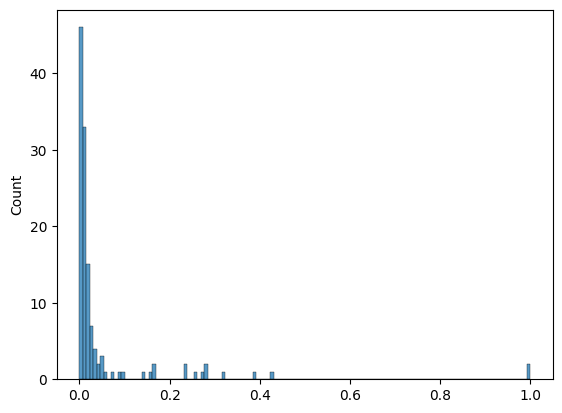

In [623]:
import seaborn
plt_set={}
for k,v in jaccard_set.items():
    plt_set[k] = v[0]

seaborn.histplot(plt_set)
plt.show()

As can be seen above, there are a few items with a score of 1.0 but most have a jaccard similarity of around 0

In [624]:
more_than_50 = [(k,v) for k,v in jaccard_set.items() if v[0] > 0.3]
print(len(more_than_50))
more_than_50


5


[(57, [0.32275132275132273, 7887, 8008]),
 (108, [0.38461538461538464, 36979, 37015]),
 (123, [1.0, 43085, 43099]),
 (128, [0.42857142857142855, 45258, 45990]),
 (130, [1.0, 46389, 46403])]

As can be seen, exactly 1 pair has a similarity of more than 0.5. Namely documents 123 and 130

In [625]:
data_content[46389]

'’’ ’Astrophysicist and StarTalk Radio host  sits down with George Takei, to talk about everything else. ’'

In [626]:
data_content[46403]

'’’ ’Astrophysicist and StarTalk Radio host  sits down with George Takei, to talk about everything else. ’'

As can be seen above, the documents are indeed quite similar